In [1]:
import torch
import gpytorch
from botorch.models import FixedNoiseGP, SingleTaskGP
from botorch.acquisition.analytic import ExpectedImprovement
from botorch.models.transforms.outcome import Standardize
from gpytorch.kernels import ScaleKernel
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model
from scipy.stats import norm
from sklearn.decomposition import PCA
import math 
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import time

# config plot settings
plt.rcParams["font.size"] = 16

In [2]:
###
#  Load Data
###
f = h5py.File("targets_and_normalized_features.jld2", "r")
# feature matrix
X = torch.from_numpy(np.transpose(f["X"][:]))
# simulation data
y = torch.from_numpy(np.transpose(f["gcmc_y"][:]))
# associated simulation costs
cost = torch.from_numpy(np.transpose(f["gcmc_elapsed_time"][:]))

# total number of COFs in data set
nb_COFs = X.shape[0] 

print("raw data - \n\tX:", X.shape)
print("\t\ty:", y.shape)
print("\t\tcost: ", cost.shape)    
    
print("\nEnsure features are normalized - ")
print("max:\n", torch.max(X, 0).values)
print("min:\n", torch.min(X, 0).values)

raw data - 
	X: torch.Size([608, 14])
		y: torch.Size([608])
		cost:  torch.Size([608])

Ensure features are normalized - 
max:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       dtype=torch.float64)
min:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)


In [3]:
X_unsqueezed = X.unsqueeze(1)

## Helper Functions

#### Construct Initial Inputs

In [4]:
# find COF closest to the center of feature space
def get_initializing_COF(X):
    # center of feature space
    feature_center = np.ones(X.shape[1]) * 0.5
    # max possible distance between normalized features
    return np.argmin(np.linalg.norm(X - feature_center, axis=1))

def diverse_set(X, train_size):
    # initialize with one random point; pick others in a max diverse fashion
    ids_train = [get_initializing_COF(X)]
    # select remaining training points
    for j in range(train_size - 1):
        # for each point in data set, compute its min dist to training set
        dist_to_train_set = np.linalg.norm(X - X[ids_train, None, :], axis=2)
        assert np.shape(dist_to_train_set) == (len(ids_train), nb_COFs)
        min_dist_to_a_training_pt = np.min(dist_to_train_set, axis=0)
        assert np.size(min_dist_to_a_training_pt) == nb_COFs
        
        # acquire point with max(min distance to train set) i.e. Furthest from train set
        ids_train.append(np.argmax(min_dist_to_a_training_pt))
    assert np.size(np.unique(ids_train)) == train_size # must be unique
    return np.array(ids_train)

In [5]:
# construct feature matrix of acquired points
def build_X_train(ids_acquired):
    return X[ids_acquired, :]

# construct output vector for acquired points
def build_y_train(ids_acquired):
    return y[ids_acquired].unsqueeze(-1)

# construct vector to track accumulated cost of acquired points
def build_cost(ids_acquired):
    return cost[ids_acquired]

#### Bayesian Algorithm

In [6]:
def run_Bayesian_optimization(nb_iterations, nb_COFs_initialization,
                              store_explore_exploit_terms=True, use_diverse_set=True):
    assert nb_iterations > nb_COFs_initialization
    ###
    #  Initialize system
    ###
    # select initial COFs for training data
    if use_diverse_set:
        # initialize with set maximizing diversity
        ids_acquired = diverse_set(X, nb_COFs_initialization)
    else:
        # initialize with random set
        ids_acquired = np.random.choice(np.arange((nb_COFs)), size=nb_COFs_initialization, replace=False)
    
    # track of exploration vs. exploitation terms 
    if store_explore_exploit_terms:
        explore_exploit_balance = np.array([(np.NaN, np.NaN) for i in range(nb_iterations)])
    
    # construct initial training sets
    X_train = build_X_train(ids_acquired)
    y_train = build_y_train(ids_acquired)
    # standardize outputs using *only currently acquired data*
    y_train = (y_train - torch.mean(y_train)) / torch.std(y_train)
    
    ###
    #  itterate through remaining budget using BO
    ###
    for i in range(nb_COFs_initialization, nb_iterations):
        # construct and fit GP model
        model = SingleTaskGP(X_train, y_train)
        mll   = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_model(mll)
        # use Expected improvement acquisition function
        acq_fn   = ExpectedImprovement(model, best_f=y_train.max().item())
        acq_vals = acq_fn.forward(X.unsqueeze(1))
        # get the id for the COF with highest acquisition value currently not in training set
        ids_sorted_by_aquisition = acq_vals.argsort(descending=True)
        for id_max in ids_sorted_by_aquisition:
            if not id_max.item() in ids_acquired:
                id_max_acq = id_max.item()
                break
        ###
        #  acquire this COF
        ###
        ids_acquired = np.concatenate((ids_acquired, [id_max_acq]))
        
        ###
        #  Track explore-exploit values
        ###
        if store_explore_exploit_terms:
            y_mu = model.posterior(X_unsqueezed[id_max_acq]).mean.squeeze().detach().numpy()
            y_sigma = np.sqrt(model.posterior(X_unsqueezed[id_max_acq]).variance.squeeze().detach().numpy())
            y_max = y_train.max().item()
            
            z = (y_mu - y_max) / y_sigma
            explore_term = y_sigma * norm.pdf(z)
            exploit_term = (y_mu - y_max) * norm.cdf(z)
            # check against BO torch's EI.
            assert np.isclose(explore_term + exploit_term, acq_vals[id_max_acq].item())
            explore_exploit_balance[i] = (explore_term, exploit_term)
        
        ###
        #  update training data; start over to normalize properly
        ###
        X_train = build_X_train(ids_acquired)
        y_train = build_y_train(ids_acquired)
        # standardize outputs using *only currently acquired data*
        y_train = (y_train - torch.mean(y_train)) / torch.std(y_train)
    
    # check budget constraint is stisfied
    assert np.size(ids_acquired) == nb_iterations
    return ids_acquired, explore_exploit_balance

## Run BO

In [7]:
nb_iterations = 100
nb_COFs_initialization = 3

ids, eeb = run_Bayesian_optimization(nb_iterations, nb_COFs_initialization)

cost_acquired = build_cost(ids)

#### PCA of BO

In [8]:
pca = PCA(n_components=2)
pca.fit(X)
X_2D = pca.transform(X)

## Random Search

In [9]:
nb_runs = 100

rs_res = dict()
rs_res['ids_acquired'] = []

for r in range(nb_runs):
    rs_ids_acquired = np.random.choice(range(nb_COFs), replace=False, size=nb_iterations)
    rs_res['ids_acquired'].append(rs_ids_acquired)

In [10]:
# get y_max acquired up to iteration i for i = 1,2,...
def y_max(res):
    y_max_mu      = np.zeros(nb_iterations)
    y_max_sig_bot = np.zeros(nb_iterations)
    y_max_sig_top = np.zeros(nb_iterations)
    
    for i in range(1, nb_iterations+1):
        # max value acquired up to this point
        y_maxes = np.array([max(y[res['ids_acquired'][r]][:i]) for r in range(nb_runs)])
        assert np.size(y_maxes) == nb_runs
        y_max_mu[i-1]      = np.mean(y_maxes)
        y_max_sig_bot[i-1] = np.std(y_maxes[y_maxes < y_max_mu[i-1]])
        y_max_sig_top[i-1] = np.std(y_maxes[y_maxes > y_max_mu[i-1]])
    return y_max_mu, y_max_sig_bot, y_max_sig_top

y_max_mu_rs, y_max_sig_bot_rs, y_max_sig_top_rs = y_max(rs_res)

## Plots

#### Search Efficiency and Cost Analysis

In [29]:
y_max = np.zeros(nb_iterations)
    
for i in range(1, nb_iterations+1):
    # max value acquired up to this point
    current_max = max(y[ids[:i]])
    y_max[i-1] = current_max
    
y_max

array([ 3.83127625,  3.83127625, 14.01751536, 15.76606426, 15.76606426,
       15.76606426, 15.76606426, 15.76606426, 15.76606426, 15.76606426,
       15.76606426, 15.76606426, 15.76606426, 15.76606426, 15.76606426,
       15.76606426, 15.76606426, 15.76606426, 15.76606426, 15.76606426,
       15.76606426, 15.76606426, 15.76606426, 15.76606426, 15.76606426,
       15.76606426, 15.76606426, 18.17097951, 18.17097951, 18.17097951,
       18.17097951, 18.17097951, 18.17097951, 18.17097951, 18.17097951,
       18.17097951, 18.17097951, 18.17097951, 18.17097951, 18.17097951,
       18.17097951, 18.17097951, 18.17097951, 18.17097951, 18.53448595,
       18.53448595, 18.53448595, 18.53448595, 18.53448595, 18.53448595,
       18.53448595, 18.53448595, 18.53448595, 18.53448595, 18.53448595,
       18.53448595, 18.53448595, 18.53448595, 18.53448595, 18.53448595,
       18.53448595, 18.53448595, 18.53448595, 18.53448595, 18.53448595,
       18.53448595, 18.53448595, 18.53448595, 18.53448595, 18.53

#### Principle Component Analysis

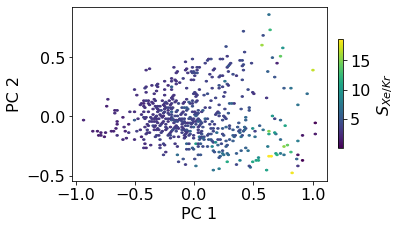

In [12]:
#low dimensional (PCA) visualization of the entire dataset
plt.hexbin(X_2D[:, 0], X_2D[:, 1], C=y)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
cb = plt.colorbar(fraction=0.02, pad=0.04)
cb.set_label(label="$S_{Xe/Kr}$")
plt.xticks()
plt.yticks()
plt.gca().set_aspect('equal', 'box')
plt.tight_layout()
# plt.savefig('feature_space_colored_by_DC.pdf')
plt.show()

In [ ]:
which_BO_run = 1

nb_acquired = [nb_COFs_initialization, 20, 40, 60, 80]
max_y_seen = np.zeros(len(nb_acquired))
fig, ax = plt.subplots(1, len(nb_acquired), sharey=True, sharex=True, figsize=[3*6.4, 4.8])
# gray background
for a in ax:
    a.set_aspect('equal', 'box')
    a.hexbin(X_2D[:, 0], X_2D[:, 1], C=0.3 * np.ones(nb_COFs), cmap="binary", vmin=0, vmax=1)
    
for i in range(len(nb_acquired)):
    ids_acquired = bo_res['ids_acquired'][which_BO_run][:nb_acquired[i]]
    max_y_seen[i] = np.max(y[ids_acquired])
    assert len(ids_acquired) == nb_acquired[i]
    # use above colorbar to assign color!
    ax[i].scatter(X_2D[ids_acquired, 0], X_2D[ids_acquired, 1], 
                  c=y[ids_acquired], marker="+", s=55, vmin=cb.vmin, vmax=cb.vmax)
    if i == 0:
        ax[i].set_title('(initialization)\n{} acquired COFs'.format(nb_acquired[i]))
    else:
        ax[i].set_title('{} acquired COFs'.format(nb_acquired[i]))
    ax[i].tick_params(axis='x')
ax[0].set_ylabel('PC 2', fontsize=14)

ax[2].tick_params(axis='y', labelsize=0)


fig.text(0.5, 0.2, 'PC 1', ha='center')
plt.tight_layout()
plt.savefig("feature_space_acquired_COFs.pdf", bbox_inches="tight")